<a href="https://colab.research.google.com/github/dmosh/cvexam/blob/main/Crop_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this practical examination you will complete a significant project in computer vision that uses material that you learned in the course. The goal of this project is to perform banana crop detection from a set of garden images.

We follow a set of step for this classification
1. Images are changed into grayscale
2. For each image, generate its feature descriptor while using SIFT
3. Stack the features vertically to create a NumPy array (feature array)
4. Perform k-means clustering on the feature array to obtain the centers of the centroid.
5. Uses the centers obtained to perform a bag of features. This assigns the features which are similar to a specific cluster.
6. Split the dataset formed at step 5 into train and test sets at an 80:20 ratio respectively.
7. Naive Bayes for each threshold needed for the SIFT until you obtain a good classification.
8. Evaluate the classifications using accuracy, precision, recall, F1





In [ ]:
# mounting the drive to read the files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# importing necessary libraries
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import glob
import matplotlib.pyplot as plt
from skimage import io
import PIL
import PIL.Image
from skimage import filters
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import time

In [ ]:
# reading cropped images from Banana and cassava
import pathlib
data = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/CV/dataset/annotated/ml dataset/Maize')
maize_images = list(data.glob('*.jpg'))
data = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/CV/dataset/annotated/ml dataset/Cassava')
cassava_images = list(data.glob('*.jpg'))
data = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/CV/dataset/annotated/ml dataset/Coffee')
coffee_images = list(data.glob('*.jpg'))
#print(len(coffee_images))

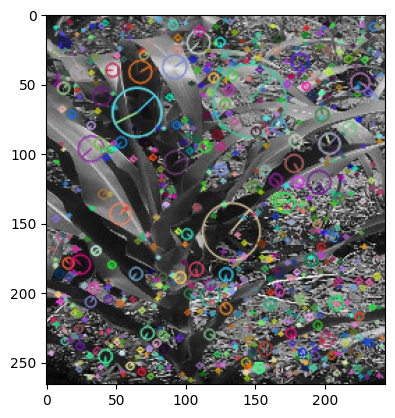

In [ ]:
# using SIFT to extract features
img = cv2.imread(str(maize_images[0]))
sift = cv2.xfeatures2d.SIFT_create()
gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#plt.imshow(gray)
kp = sift.detect(gray, None)

# Marking the keypoint on the image using circles
sift_img=cv2.drawKeypoints(gray ,
                      kp ,
                      img ,
                      flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(sift_img)

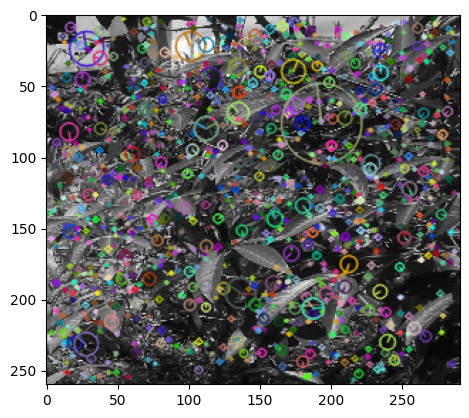

In [ ]:
# using SIFT to extract features for cassava
img = cv2.imread(str(cassava_images[4]))
sift = cv2.xfeatures2d.SIFT_create()
gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
kp = sift.detect(gray, None)

# Marking the keypoint on the image using circles
sift_img=cv2.drawKeypoints(gray ,
                      kp ,
                      img ,
                      flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(sift_img)

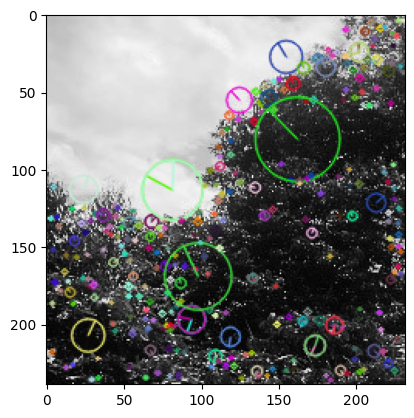

In [ ]:
# using SIFT to extract features
img = cv2.imread(str(coffee_images[9]))
sift = cv2.xfeatures2d.SIFT_create()
gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
kp = sift.detect(gray, None)

# Marking the keypoint on the image using circles
sift_img=cv2.drawKeypoints(gray ,
                      kp ,
                      img ,
                      flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(sift_img)

In [ ]:
# getting features for different thresholds
def get_k_shift_thresh(thresh):
  def CalcFeatures(img, th):
    sift = cv2.xfeatures2d.SIFT_create(th)
    kp, des = sift.detectAndCompute(img, None)
    return des

  features = []
  for file in maize_images:
    img = cv2.imread(str(file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_des = CalcFeatures(img, thresh)
    if img_des is not None:
      features.append(img_des)
  for file in cassava_images:
    img = cv2.imread(str(file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_des = CalcFeatures(img, thresh)
    if img_des is not None:
      features.append(img_des)

  for file in coffee_images:
    img = cv2.imread(str(file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_des = CalcFeatures(img, thresh)
    if img_des is not None:
      features.append(img_des)
  features = np.vstack(features)

  return features

In [ ]:
# getting the features per threshold
features_per_threshold = {}
for i in range(5,26,5):
  features_per_threshold[i] = get_k_shift_thresh(i)

**Method structure**
Combining all the above steps into one main algorithim

In [ ]:
from sklearn.naive_bayes import GaussianNB

def sift_svm_naive_classifier(thresh):

  t0 = time.time()

  def CalcFeatures(img, th):
    sift = cv2.xfeatures2d.SIFT_create(th)
    kp, des = sift.detectAndCompute(img, None)
    return des

  '''
  All the files appended to the image_path list are passed through the
  CalcFeatures functions which returns the descriptors which are
  appended to the features list and then stacked vertically in the form
  of a numpy array.
  '''

  features = []
  for file in maize_images:
    img = cv2.imread(str(file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_des = CalcFeatures(img, thresh)
    if img_des is not None:
      features.append(img_des)
  for file in cassava_images:
    img = cv2.imread(str(file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_des = CalcFeatures(img, thresh)
    if img_des is not None:
      features.append(img_des)
  for file in coffee_images:
    img = cv2.imread(str(file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_des = CalcFeatures(img, thresh)
    if img_des is not None:
      features.append(img_des)
  features = np.vstack(features)

  '''
  K-Means clustering is then performed on the feature array obtained
  from the previous step. The centres obtained after clustering are
  further used for bagging of features.
  '''

  k = 150
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 0.1)
  flags = cv2.KMEANS_RANDOM_CENTERS
  compactness, labels, centres = cv2.kmeans(features, k, None, criteria, 10, flags)

  '''
  The bag_of_features function assigns the features which are similar
  to a specific cluster centre thus forming a Bag of Words approach.
  '''

  def bag_of_features(features, centres, k = 500):
      vec = np.zeros((1, k))
      for i in range(features.shape[0]):
          feat = features[i]
          diff = np.tile(feat, (k, 1)) - centres
          dist = pow(((pow(diff, 2)).sum(axis = 1)), 0.5)
          idx_dist = dist.argsort()
          idx = idx_dist[0]
          vec[0][idx] += 1
      return vec

  labels = []
  vec = []
  for file in maize_images:
    img = cv2.imread(str(file))
    img_des = CalcFeatures(img, thresh)
    if img_des is not None:
      img_vec = bag_of_features(img_des, centres, k)
      vec.append(img_vec)
      labels.append(0)
  for file in cassava_images:
    img = cv2.imread(str(file))
    img_des = CalcFeatures(img, thresh)
    if img_des is not None:
      img_vec = bag_of_features(img_des, centres, k)
      vec.append(img_vec)
      labels.append(1)
  for file in coffee_images:
    img = cv2.imread(str(file))
    img_des = CalcFeatures(img, thresh)
    if img_des is not None:
      img_vec = bag_of_features(img_des, centres, k)
      vec.append(img_vec)
      labels.append(2)
  vec = np.vstack(vec)

  '''
  Splitting the data formed into test and split data and training the
  SVM Classifier.
  '''

  X_train, X_test, y_train, y_test = train_test_split(vec, labels, test_size=0.2)
  clf = SVC()
  clf.fit(X_train, y_train)
  preds = clf.predict(X_test)
  acc = accuracy_score(y_test, preds)
  conf_mat = confusion_matrix(y_test, preds)
  # plt.imshow(conf_mat, cmap='binary')

  clf_g = GaussianNB()
  clf_g.fit(X_train, y_train)
  preds_g = clf_g.predict(X_test)
  acc_g = accuracy_score(y_test, preds_g)
  conf_mat_g = confusion_matrix(y_test, preds_g)


  t1 = time.time()

  return acc*100, conf_mat, (t1-t0), acc_g*100, conf_mat_g


accuracy = {}
accuracy_g = {}
conf_mat_lst = {}
conf_mat_lst_g = {}
timer = []
# data_analysis = {}
for i in range(5,26,5):
  print('\nCalculating for a threshold of {}'.format(i))
  data = sift_svm_naive_classifier(i)
  # accuracy.append(data[0])
  accuracy[i] = data[0]
  accuracy_g[i] = data[3]
  conf_mat = data[1]
  conf_mat_lst[i] = data[1]
  conf_mat_lst_g[i] = data[4]
  timer.append(data[2])
  print('\nSVM\nAccuracy = {}\nTime taken = {} sec\nConfusion matrix :\n{}'.format(data[0],data[2],data[1]))
  print('\nNaive Bayes\nAccuracy = {}\nTime taken = {} sec\nConfusion matrix :\n{}'.format(data[3],data[2],data[4]))

In [22]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import GaussianNB

def sift_svm_naive_classifier(thresh):

    t0 = time.time()

    def CalcFeatures(img, th):
        sift = cv2.xfeatures2d.SIFT_create(th)
        kp, des = sift.detectAndCompute(img, None)
        return des

    '''
    All the files appended to the image_path list are passed through the
    CalcFeatures functions which returns the descriptors that are
    appended to the features list and then stacked vertically in the form
    of a numpy array.
    '''

    features = []
    for file in maize_images:
        img = cv2.imread(str(file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_des = CalcFeatures(img, thresh)
        if img_des is not None:
            features.append(img_des)
    for file in cassava_images:
        img = cv2.imread(str(file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_des = CalcFeatures(img, thresh)
        if img_des is not None:
            features.append(img_des)
    for file in coffee_images:
        img = cv2.imread(str(file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_des = CalcFeatures(img, thresh)
        if img_des is not None:
            features.append(img_des)
    features = np.vstack(features)

    '''
    K-Means clustering is then performed on the feature array obtained
    from the previous step. The centers obtained after clustering are
    further used for bagging of features.
    '''

    k = 150
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 0.1)
    flags = cv2.KMEANS_RANDOM_CENTERS
    compactness, labels, centres = cv2.kmeans(features, k, None, criteria, 10, flags)

    '''
    The bag_of_features function assigns the features that are similar
    to a specific cluster center, thus forming a Bag of Words approach.
    '''

    def bag_of_features(features, centres, k=500):
        vec = np.zeros((1, k))
        for i in range(features.shape[0]):
            feat = features[i]
            diff = np.tile(feat, (k, 1)) - centres
            dist = pow(((pow(diff, 2)).sum(axis=1)), 0.5)
            idx_dist = dist.argsort()
            idx = idx_dist[0]
            vec[0][idx] += 1
        return vec

    labels = []
    vec = []
    for file in maize_images:
        img = cv2.imread(str(file))
        img_des = CalcFeatures(img, thresh)
        if img_des is not None:
            img_vec = bag_of_features(img_des, centres, k)
            vec.append(img_vec)
            labels.append(0)
    for file in cassava_images:
        img = cv2.imread(str(file))
        img_des = CalcFeatures(img, thresh)
        if img_des is not None:
            img_vec = bag_of_features(img_des, centres, k)
            vec.append(img_vec)
            labels.append(1)
    for file in coffee_images:
        img = cv2.imread(str(file))
        img_des = CalcFeatures(img, thresh)
        if img_des is not None:
            img_vec = bag_of_features(img_des, centres, k)
            vec.append(img_vec)
            labels.append(2)
    vec = np.vstack(vec)

    '''
    Splitting the data formed into test and split data and training the
    SVM Classifier.
    '''

    X_train, X_test, y_train, y_test = train_test_split(vec, labels, test_size=0.2)
    clf = SVC()
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    acc = accuracy_score(y_test, preds)
    conf_mat = confusion_matrix(y_test, preds)
    classification_rep = classification_report(y_test, preds)

    clf_g = GaussianNB()
    clf_g.fit(X_train, y_train)
    preds_g = clf_g.predict(X_test)
    acc_g = accuracy_score(y_test, preds_g)
    conf_mat_g = confusion_matrix(y_test, preds_g)
    classification_rep_g = classification_report(y_test, preds_g)

    t1 = time.time()

    return acc * 100, conf_mat, (t1 - t0), acc_g * 100, conf_mat_g, classification_rep, classification_rep_g


accuracy = {}
accuracy_g = {}
conf_mat_lst = {}
conf_mat_lst_g = {}
timer = []

for i in range(5, 26, 5):
    print('\nCalculating for a threshold of {}'.format(i))
    data = sift_svm_naive_classifier(i)
    accuracy[i] = data[0]
    accuracy_g[i] = data[3]
    conf_mat_lst[i] = data[1]
    conf_mat_lst_g[i] = data[4]
    timer.append(data[2])
    print('\nSVM\nAccuracy = {}\nTime taken = {} sec\nConfusion matrix:\n{}\nClassification Report:\n{}'.format(data[0], data[2], data[1], data[5]))
    print('\nNaive Bayes\nAccuracy = {}\nTime taken = {} sec\nConfusion matrix:\n{}\nClassification Report:\n{}'.format(data[3], data[2], data[4], data[6]))



Calculating for a threshold of 5


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



SVM
Accuracy = 56.896551724137936
Time taken = 50.06029033660889 sec
Confusion matrix:
[[21 12  0]
 [10 12  0]
 [ 3  0  0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.64      0.63        33
           1       0.50      0.55      0.52        22
           2       0.00      0.00      0.00         3

    accuracy                           0.57        58
   macro avg       0.37      0.39      0.38        58
weighted avg       0.54      0.57      0.55        58


Naive Bayes
Accuracy = 36.206896551724135
Time taken = 50.06029033660889 sec
Confusion matrix:
[[ 9 15  9]
 [ 2 11  9]
 [ 1  1  1]]
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.27      0.40        33
           1       0.41      0.50      0.45        22
           2       0.05      0.33      0.09         3

    accuracy                           0.36        58
   macro avg       0.40      0.37      0.31

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



SVM
Accuracy = 44.827586206896555
Time taken = 47.64446759223938 sec
Confusion matrix:
[[17  6  0]
 [16  9  0]
 [ 6  4  0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.74      0.55        23
           1       0.47      0.36      0.41        25
           2       0.00      0.00      0.00        10

    accuracy                           0.45        58
   macro avg       0.30      0.37      0.32        58
weighted avg       0.38      0.45      0.39        58


Naive Bayes
Accuracy = 44.827586206896555
Time taken = 47.64446759223938 sec
Confusion matrix:
[[ 2 18  3]
 [ 1 20  4]
 [ 3  3  4]]
Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.09      0.14        23
           1       0.49      0.80      0.61        25
           2       0.36      0.40      0.38        10

    accuracy                           0.45        58
   macro avg       0.39      0.43      0.37

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



SVM
Accuracy = 65.51724137931035
Time taken = 51.326215505599976 sec
Confusion matrix:
[[26  7  0]
 [ 9 12  0]
 [ 1  3  0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.79      0.75        33
           1       0.55      0.57      0.56        21
           2       0.00      0.00      0.00         4

    accuracy                           0.66        58
   macro avg       0.42      0.45      0.44        58
weighted avg       0.61      0.66      0.63        58


Naive Bayes
Accuracy = 43.103448275862064
Time taken = 51.326215505599976 sec
Confusion matrix:
[[11 19  3]
 [ 5 10  6]
 [ 0  0  4]]
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.33      0.45        33
           1       0.34      0.48      0.40        21
           2       0.31      1.00      0.47         4

    accuracy                           0.43        58
   macro avg       0.45      0.60      0.4

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



SVM
Accuracy = 60.3448275862069
Time taken = 49.756184339523315 sec
Confusion matrix:
[[25  4  0]
 [17 10  0]
 [ 1  1  0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.86      0.69        29
           1       0.67      0.37      0.48        27
           2       0.00      0.00      0.00         2

    accuracy                           0.60        58
   macro avg       0.42      0.41      0.39        58
weighted avg       0.60      0.60      0.57        58


Naive Bayes
Accuracy = 50.0
Time taken = 49.756184339523315 sec
Confusion matrix:
[[23  2  4]
 [14  4  9]
 [ 0  0  2]]
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.79      0.70        29
           1       0.67      0.15      0.24        27
           2       0.13      1.00      0.24         2

    accuracy                           0.50        58
   macro avg       0.47      0.65      0.39        58
wei

In [11]:
sum(accuracy.values())/len(accuracy.values())

56.55172413793103

In [12]:
sum(accuracy_g.values())/len(accuracy_g.values())


48.27586206896552

In [13]:
conf_mat_lst

{5: array([[26,  2,  0],
        [17,  6,  0],
        [ 5,  2,  0]]),
 10: array([[23,  5,  1],
        [16,  7,  0],
        [ 2,  3,  1]]),
 15: array([[21,  5,  0],
        [13, 10,  0],
        [ 4,  5,  0]]),
 20: array([[24,  3,  0],
        [12, 13,  0],
        [ 3,  3,  0]]),
 25: array([[21,  6,  0],
        [ 8, 11,  0],
        [ 3,  8,  1]])}

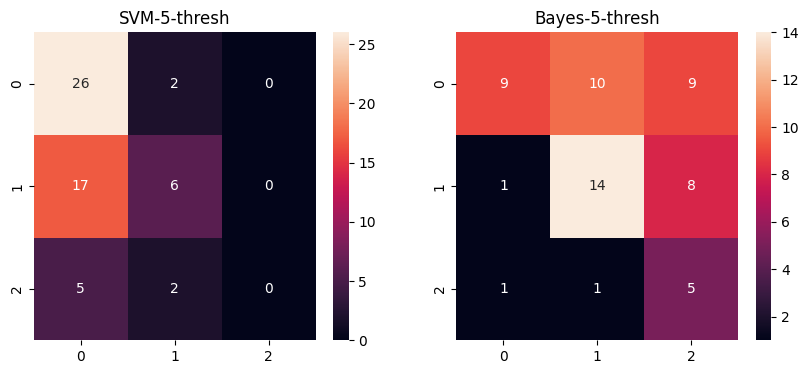

In [15]:
import seaborn as sns
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10, 4))
sns.heatmap(conf_mat_lst[5], annot=True, fmt='g',ax=ax1)
sns.heatmap(conf_mat_lst_g[5], annot=True, fmt='g',ax=ax2)
ax1.set_title('SVM-5-thresh')
ax2.set_title('Bayes-5-thresh')
plt.show()

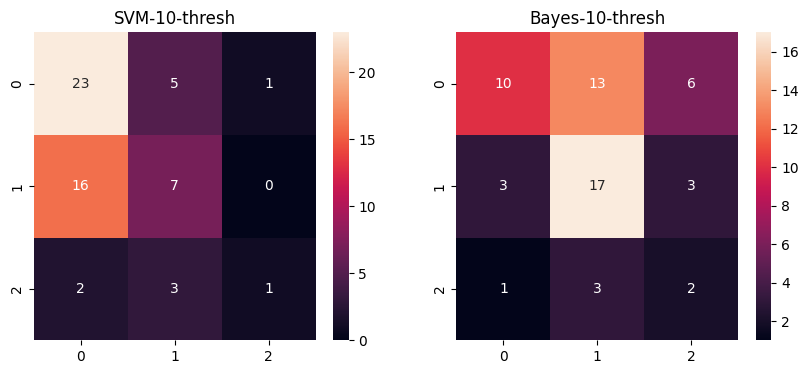

In [16]:
import seaborn as sns
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 4))
sns.heatmap(conf_mat_lst[10], annot=True, fmt='g',ax=ax1)
sns.heatmap(conf_mat_lst_g[10], annot=True, fmt='g',ax=ax2)
ax1.set_title('SVM-10-thresh')
ax2.set_title('Bayes-10-thresh')
plt.show()

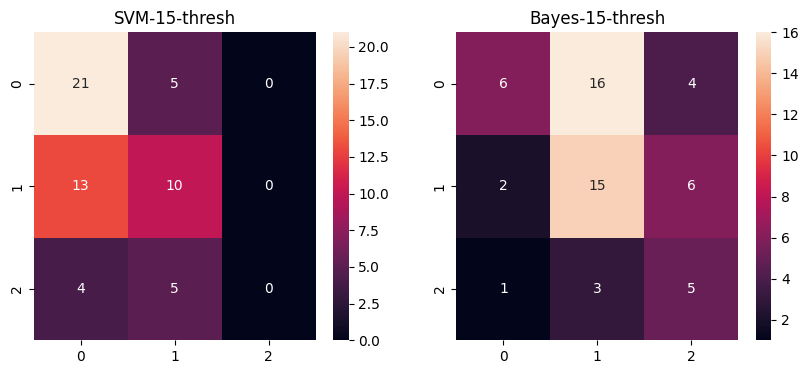

In [17]:
import seaborn as sns
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 4))
sns.heatmap(conf_mat_lst[15], annot=True, fmt='g',ax=ax1)
sns.heatmap(conf_mat_lst_g[15], annot=True, fmt='g',ax=ax2)
ax1.set_title('SVM-15-thresh')
ax2.set_title('Bayes-15-thresh')
plt.show()

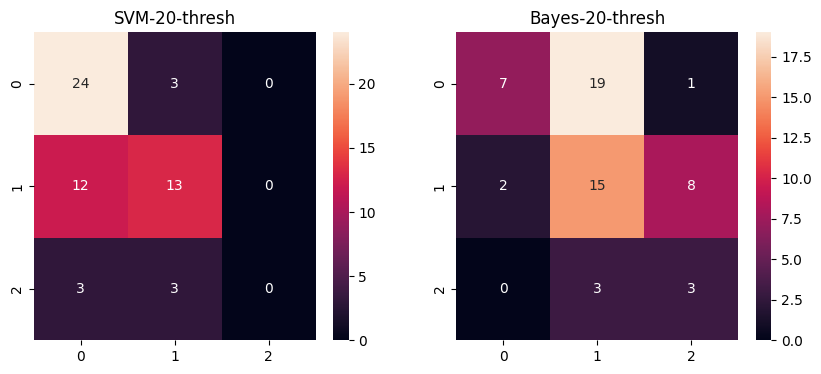

In [18]:
import seaborn as sns
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 4))
sns.heatmap(conf_mat_lst[20], annot=True, fmt='g',ax=ax1)
sns.heatmap(conf_mat_lst_g[20], annot=True, fmt='g',ax=ax2)
ax1.set_title('SVM-20-thresh')
ax2.set_title('Bayes-20-thresh')
plt.show()

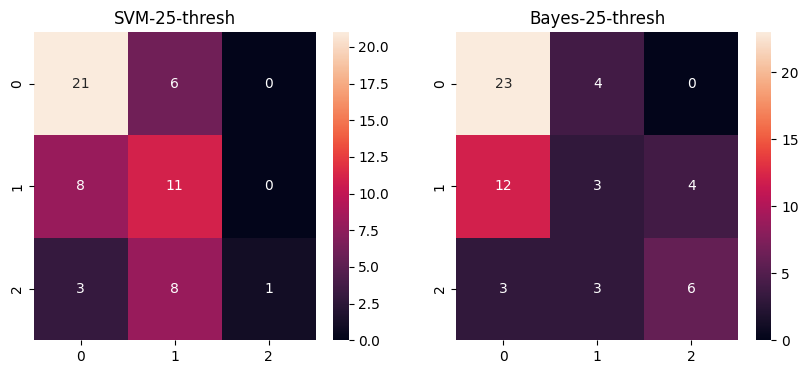

In [19]:
import seaborn as sns
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 4))
sns.heatmap(conf_mat_lst[25], annot=True, fmt='g',ax=ax1)
sns.heatmap(conf_mat_lst_g[25], annot=True, fmt='g',ax=ax2)
ax1.set_title('SVM-25-thresh')
ax2.set_title('Bayes-25-thresh')
plt.show()

In [20]:
# comparing there accuracys
import pandas as pd
combined_dict = {"svm":accuracy, "bayes":accuracy_g}
combined_dict
df = pd.DataFrame(combined_dict)
df

,svm,bayes
5,55.172414,48.275862
10,53.448276,50.000000
15,53.448276,44.827586
20,63.793103,43.103448
25,56.896552,55.172414


In [ ]:
from sklearn.naive_bayes import GaussianNB

Text(0.5, 0, 'SIFT-Threshold')

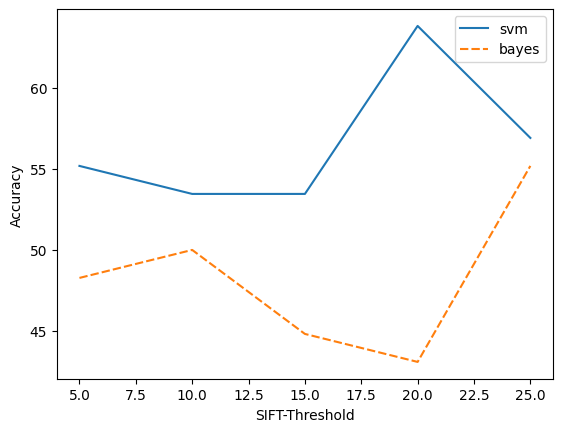

In [21]:
plot = sns.lineplot(data=df)
plot.set_ylabel("Accuracy")
plot.set_xlabel("SIFT-Threshold")
